In [2]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
# Configure GPU settings (place at start of notebook)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Memory growth and optimized cuDNN
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.optimizer.set_jit(True)  # Enable XLA compilation
        tf.config.optimizer.set_experimental_options(
            {'layout_optimizer': True, 'constant_folding': True}
        )
    except RuntimeError as e:
        print(e)

In [53]:
# Updated configuration
SAMPLE_RATE = 16000        # Audio sample rate (Hz)
MAX_DURATION = 2           # 2-second audio clips
N_MELS = 64               # Number of Mel bands
BATCH_SIZE = 64            # Training batch size
EPOCHS = 20                # Number of training epochs
LEARNING_RATE = 0.0001     # Learning rate
PATIENCE = 5               # Early stopping patience

# Calculate fixed dimensions
N_FFT = 512               # FFT window size
HOP_LENGTH = 512           # Number of samples between frames
AUDIO_LENGTH = SAMPLE_RATE * MAX_DURATION
SPEC_WIDTH = 1 + (AUDIO_LENGTH // HOP_LENGTH)  # 63 for 2s at 16000Hz
DATA_PATH = "data"
MODEL_PATH = "model.keras"

In [54]:
def process_audio(file_path):
    """Optimized audio preprocessing"""
    path_str = file_path.numpy().decode('utf-8')
    audio, _ = librosa.load(path_str, sr=SAMPLE_RATE, duration=MAX_DURATION, mono=True)
    
    # Fixed length processing (faster than conditional padding)
    audio = librosa.util.fix_length(audio, size=AUDIO_LENGTH)
    
    # Faster Mel spectrogram computation
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=SAMPLE_RATE,
        n_mels=N_MELS,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
    )
    log_mel = librosa.power_to_db(mel_spec, ref=1.0)  # Simplified reference
    log_mel = (log_mel + 40) / 40  # Simplified normalization (assumes -40 to 0 dB range)
    log_mel = log_mel[..., np.newaxis]
    
    return tf.ensure_shape(log_mel, [N_MELS, SPEC_WIDTH, 1])

In [63]:
def augment_audio(audio):
    """Simple and fast audio augmentation using NumPy"""
    if np.random.rand() > 0.5:
        audio = audio * np.random.uniform(0.8, 1.2)  # Random gain using NumPy
    return audio

In [25]:
def plot_spectrogram(spec, title="Mel Spectrogram"):
    """Visualize a spectrogram"""
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

In [64]:
def create_dataset(data_path, augment=False, shuffle=True):
    """Optimized TensorFlow Dataset with explicit shape enforcement"""
    real_files = [os.path.join(data_path, "real", f) for f in os.listdir(os.path.join(data_path, "real")) if f.endswith('.wav')]
    fake_files = [os.path.join(data_path, "fake", f) for f in os.listdir(os.path.join(data_path, "fake")) if f.endswith('.wav')]
    
    file_paths = real_files + fake_files
    labels = [0] * len(real_files) + [1] * len(fake_files)
    
    def process_file(file_path, label):
        mel_spec = process_audio(file_path)
        if augment:
            path_str = file_path.numpy().decode('utf-8')
            audio, _ = librosa.load(path_str, sr=SAMPLE_RATE, duration=MAX_DURATION, mono=True)
            audio = augment_audio(audio)  # Returns NumPy array
            mel_spec = librosa.feature.melspectrogram(
                y=audio,
                sr=SAMPLE_RATE,
                n_mels=N_MELS,
                n_fft=N_FFT,
                hop_length=HOP_LENGTH,
            )
            mel_spec = librosa.power_to_db(mel_spec, ref=1.0)
            mel_spec = (mel_spec + 40) / 40
            mel_spec = mel_spec[..., np.newaxis]
            mel_spec = tf.ensure_shape(mel_spec, [N_MELS, SPEC_WIDTH, 1])
        return mel_spec, label
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    
    if shuffle:
        dataset = dataset.shuffle(len(file_paths), reshuffle_each_iteration=True)
    
    dataset = dataset.map(
        lambda x, y: tf.py_function(
            func=process_file,
            inp=[x, y],
            Tout=[tf.float32, tf.int32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Explicitly enforce shapes after py_function
    dataset = dataset.map(
        lambda x, y: (tf.ensure_shape(x, [N_MELS, SPEC_WIDTH, 1]), tf.ensure_shape(y, [])),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    dataset = dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [65]:
def build_model(input_shape=(N_MELS, SPEC_WIDTH, 1)):
    """Simplified and faster CNN model with explicit Input layer"""
    model = models.Sequential([
        layers.Input(shape=input_shape),  # Explicit input layer
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32 for mixed precision
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [66]:
# Create datasets
train_ds = create_dataset(os.path.join(DATA_PATH, "training"), augment=True, shuffle=True)
val_ds = create_dataset(os.path.join(DATA_PATH, "validation"), augment=False, shuffle=False)
    
model = build_model()
    
early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True
    )
model_checkpoint = callbacks.ModelCheckpoint(
        MODEL_PATH,
        monitor='val_loss',
        save_best_only=True
    )
    
history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[early_stopping, model_checkpoint],
        verbose=2
    )

Epoch 1/20
219/219 - 217s - 993ms/step - accuracy: 0.6778 - loss: 0.5976 - val_accuracy: 0.8273 - val_loss: 0.4483
Epoch 2/20
219/219 - 17s - 80ms/step - accuracy: 0.8262 - loss: 0.4203 - val_accuracy: 0.8358 - val_loss: 0.3724
Epoch 3/20
219/219 - 17s - 79ms/step - accuracy: 0.8570 - loss: 0.3566 - val_accuracy: 0.8524 - val_loss: 0.3362
Epoch 4/20
219/219 - 18s - 80ms/step - accuracy: 0.8699 - loss: 0.3175 - val_accuracy: 0.8567 - val_loss: 0.3156
Epoch 5/20
219/219 - 17s - 78ms/step - accuracy: 0.8844 - loss: 0.2844 - val_accuracy: 0.8531 - val_loss: 0.3102
Epoch 6/20
219/219 - 17s - 77ms/step - accuracy: 0.8979 - loss: 0.2543 - val_accuracy: 0.8875 - val_loss: 0.2515
Epoch 7/20
219/219 - 17s - 78ms/step - accuracy: 0.9056 - loss: 0.2352 - val_accuracy: 0.8882 - val_loss: 0.2409
Epoch 8/20
219/219 - 17s - 78ms/step - accuracy: 0.9161 - loss: 0.2138 - val_accuracy: 0.8793 - val_loss: 0.2568
Epoch 9/20
219/219 - 17s - 78ms/step - accuracy: 0.9220 - loss: 0.2004 - val_accuracy: 0.8889 

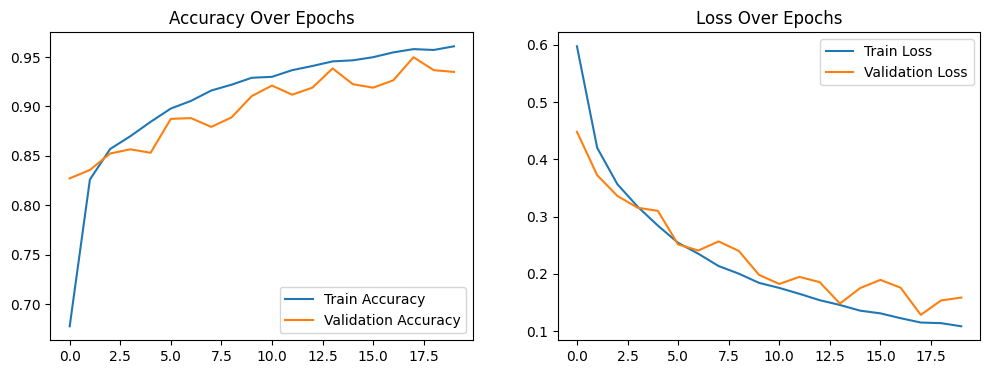

In [67]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()


In [68]:
model.save(MODEL_PATH)

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 451ms/step - accuracy: 0.8497 - loss: 0.3508 - precision_1: 0.7992 - recall_1: 0.9300

Test Accuracy: 84.38%
Test Precision: 80.26%
Test Recall: 91.18%

Classification Report:
              precision    recall  f1-score   support

        Real       0.90      0.78      0.83       544
        Fake       0.80      0.91      0.85       544

    accuracy                           0.84      1088
   macro avg       0.85      0.84      0.84      1088
weighted avg       0.85      0.84      0.84      1088



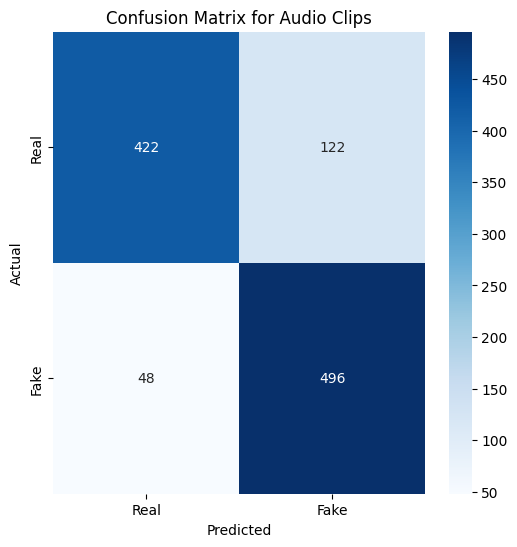

In [69]:
# Load best model
model = tf.keras.models.load_model(MODEL_PATH)

# Create test dataset - UPDATED to use create_2s_dataset instead of create_dataset
test_ds = create_dataset(os.path.join(DATA_PATH, "testing"))  # Removed BATCH_SIZE parameter

# Evaluate - UPDATED to handle the warning
model.compile(  # Recompile to ensure metrics are built
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.2%}")
print(f"Test Precision: {test_prec:.2%}")
print(f"Test Recall: {test_rec:.2%}")

# Get predictions for confusion matrix - UPDATED for batch processing
y_true = []
y_pred = []

# Process in batches for efficiency
for batch in test_ds:
    x_batch, y_batch = batch
    y_true.extend(y_batch.numpy())
    batch_preds = model.predict(x_batch, verbose=0)
    y_pred.extend((batch_preds > 0.5).astype(int).flatten())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Real", "Fake"], 
            yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Audio Clips")  # Updated title
plt.show()


In [105]:
from sklearn.metrics import precision_recall_fscore_support ,  roc_curve, auc
def analyze_results(model, test_ds):
    """Comprehensive performance analysis"""
    # Get predictions
    y_true = []
    y_pred = []
    y_score = []
    
    for x, y in test_ds.unbatch().batch(32):  # Batch for efficiency
        y_true.extend(y.numpy())
        preds = model.predict(x, verbose=0)
        y_score.extend(preds.flatten())
        y_pred.extend((preds > 0.5).astype(int).flatten())
    
    # Enhanced classification report
    print("Detailed Classification Report:")
    print(classification_report(
        y_true, y_pred, 
        target_names=["Real", "Fake"],
        digits=4
    ))
    
    # Per-class metrics
    print("\nClass-wise Performance:")
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred)
    print(f"Real Audio - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
    print(f"Fake Audio - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")
    
    # Plot confusion matrix with percentages
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Real", "Fake"], 
                yticklabels=["Real", "Fake"])
    plt.title("Counts")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Blues",
                xticklabels=["Real", "Fake"], 
                yticklabels=["Real", "Fake"])
    plt.title("Percentages")
    plt.suptitle("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

Detailed Classification Report:
              precision    recall  f1-score   support

        Real     0.8979    0.7757    0.8323       544
        Fake     0.8026    0.9118    0.8537       544

    accuracy                         0.8438      1088
   macro avg     0.8502    0.8438    0.8430      1088
weighted avg     0.8502    0.8438    0.8430      1088


Class-wise Performance:
Real Audio - Precision: 0.8979, Recall: 0.7757, F1: 0.8323
Fake Audio - Precision: 0.8026, Recall: 0.9118, F1: 0.8537


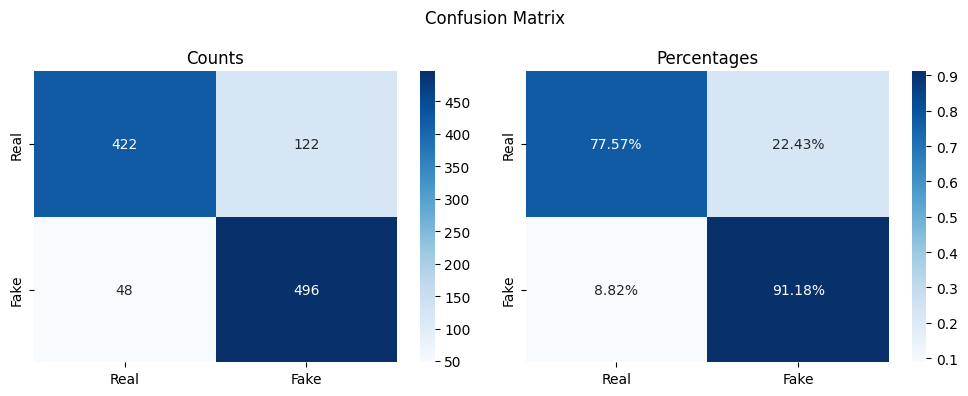

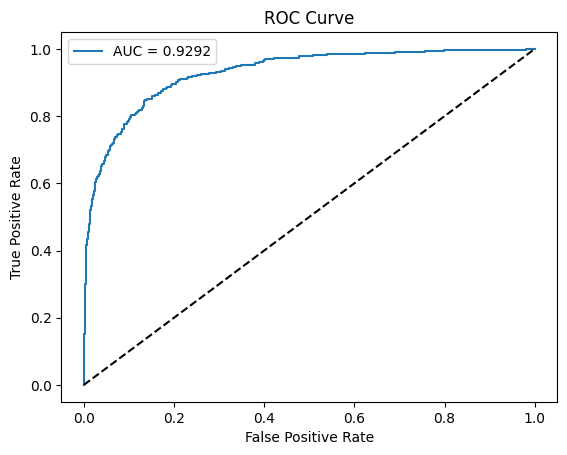

In [106]:
analyze_results(model, test_ds)

In [91]:
class AudioDeepfakeDetector:
    def __init__(self, model_path=MODEL_PATH):
        """Initialize the detector with the trained model"""
        self.model = tf.keras.models.load_model(model_path)
    
    def predict(self, audio_path):
        """Predict whether audio is real (0) or fake (1)"""
        if isinstance(audio_path, tf.Tensor):
            audio_path = audio_path.numpy().decode('utf-8')
        elif not isinstance(audio_path, str):
            audio_path = str(audio_path)
        
        # Sanitize the path to remove invalid characters
        sanitized_path = re.sub(r'[^\w\d\-_\\/.]', '_', audio_path)
        if sanitized_path != audio_path:
            print(f"Warning: Original path '{audio_path}' sanitized to '{sanitized_path}'")
            audio_path = sanitized_path
        
        try:
            features = process_audio(tf.convert_to_tensor(audio_path, dtype=tf.string))
            features = tf.expand_dims(features, axis=0)
            prediction = self.model.predict(features, verbose=0)[0][0]
            
            try:
                display(Audio(audio_path))
                # Convert tf.Tensor to NumPy array before plotting
                plot_spectrogram(features[0, :, :, 0].numpy(), 
                               title=f"Spectrogram - Predicted: {'fake' if prediction > 0.5 else 'real'}")
            except ImportError:
                print("IPython not available, skipping audio playback and spectrogram display.")
            
            return {
                "prediction": "fake" if prediction > 0.5 else "real",
                "confidence": float(prediction if prediction > 0.5 else 1 - prediction),
                "raw_score": float(prediction)
            }
        except Exception as e:
            print(f"Error processing '{audio_path}': {str(e)}")
            return None

In [92]:
def test_single_audio(audio_path):
    """Test a single audio file"""
    detector = AudioDeepfakeDetector()
    result = detector.predict(audio_path)
    if result:
        print(f"\nTesting: {audio_path}")
        print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.2%})")
        print(f"Raw Score: {result['raw_score']:.4f}")

def test_audio_folder(folder_path):
    """Test all WAV files in a folder"""
    detector = AudioDeepfakeDetector()
    results = []
    
    for file in os.listdir(folder_path):
        if file.lower().endswith('.wav'):
            file_path = os.path.join(folder_path, file)
            sanitized_path = re.sub(r'[^\w\d\-_\\/.]', '_', file_path)
            if sanitized_path != file_path:
                print(f"Warning: Original path '{file_path}' sanitized to '{sanitized_path}'")
                file_path = sanitized_path
            
            result = detector.predict(file_path)
            if result:
                results.append({
                    "file": file,
                    "prediction": result["prediction"],
                    "confidence": result["confidence"]
                })
                print(f"\nTesting: {file_path}")
                print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.2%})")
    
    return results

In [97]:
import re
def clean_dataset_files(folder_path):
    """Rename files in a folder to remove invalid characters"""
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.wav'):
                old_path = os.path.join(root, file)
                new_file = re.sub(r'[^\w\d\-_.]', '_', file)  # Replace invalid chars with '_'
                new_path = os.path.join(root, new_file)
                if old_path != new_path:
                    print(f"Renaming '{old_path}' to '{new_path}'")
                    os.rename(old_path, new_path)

# Clean the testing folder
clean_dataset_files(os.path.join(DATA_PATH, "test"))

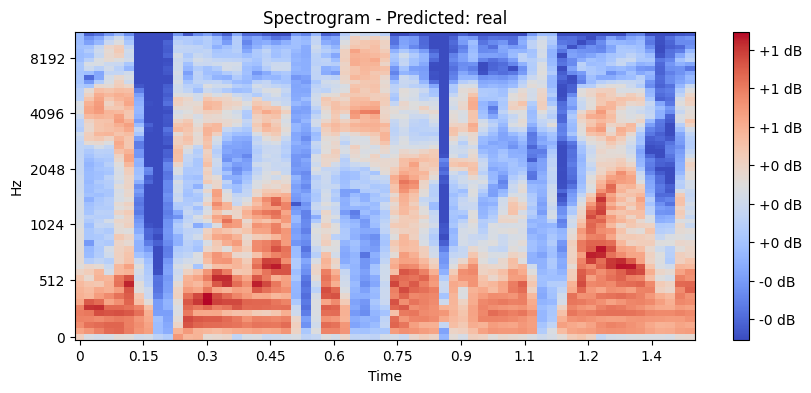


Testing: data\test\file33.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: real (Confidence: 81.32%)


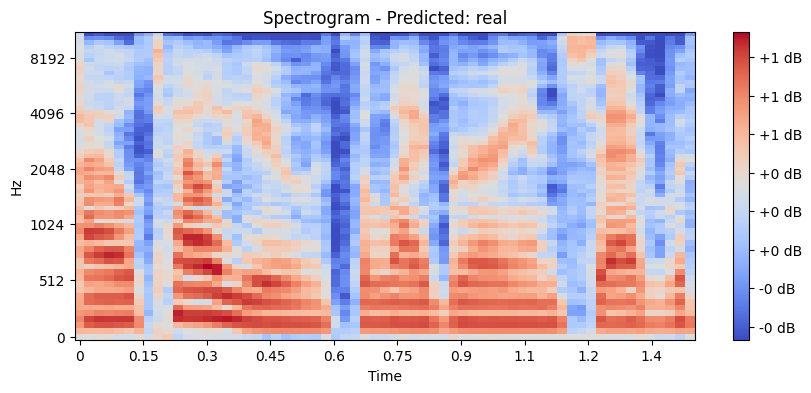


Testing: data\test\file35.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: real (Confidence: 96.44%)


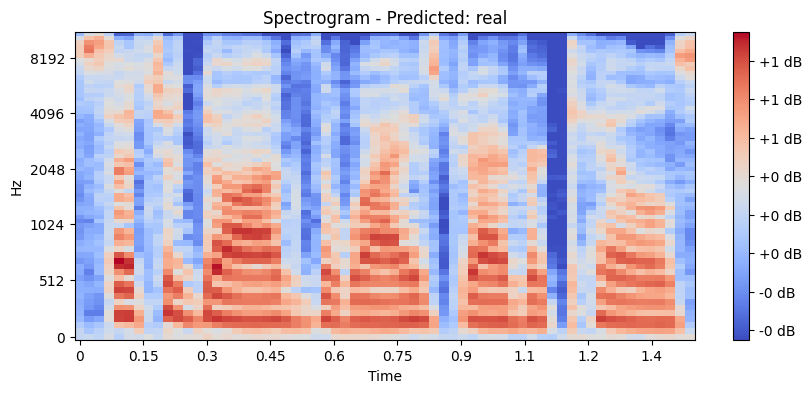


Testing: data\test\file40.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: real (Confidence: 88.99%)


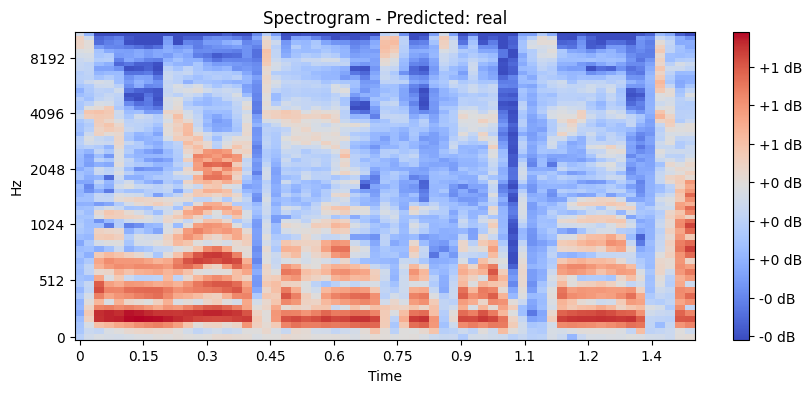


Testing: data\test\file41.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: real (Confidence: 91.96%)


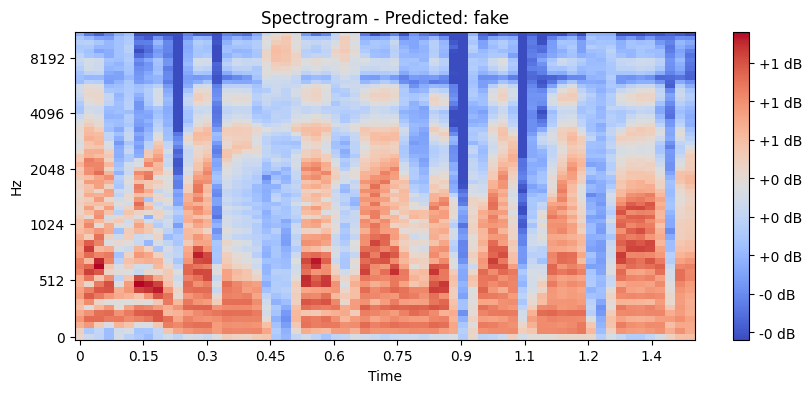


Testing: data\test\file61.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: fake (Confidence: 89.85%)


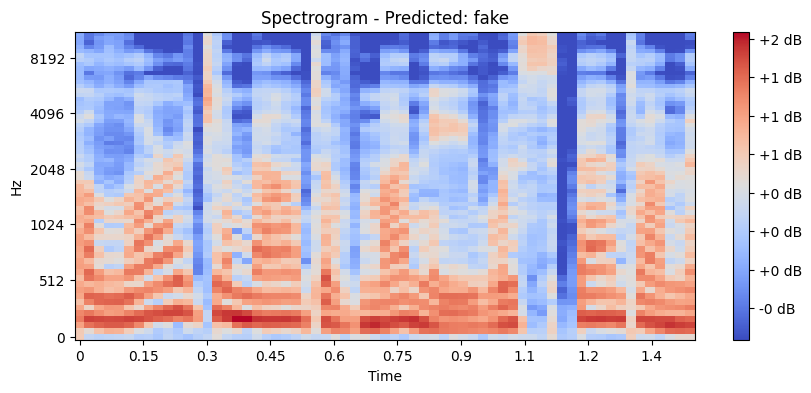


Testing: data\test\file65.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: fake (Confidence: 94.39%)


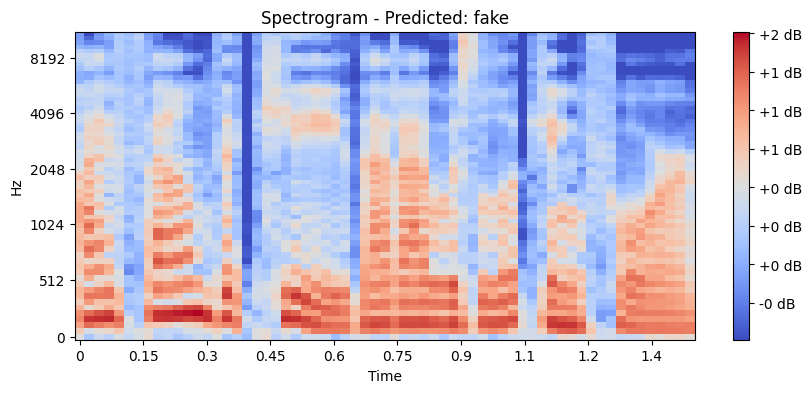


Testing: data\test\file71.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: fake (Confidence: 87.95%)


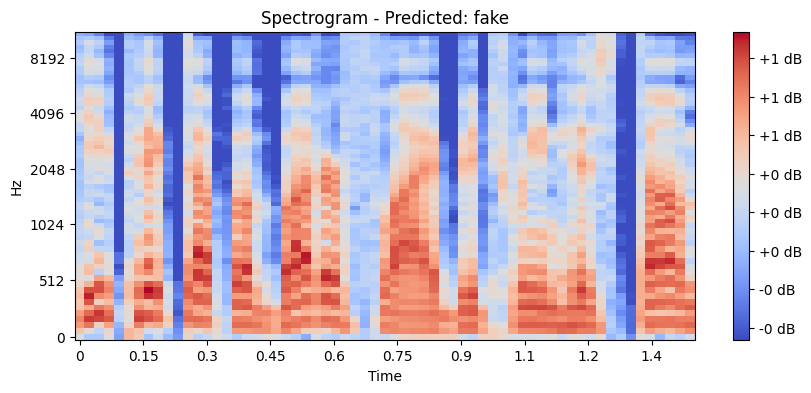


Testing: data\test\file72.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: fake (Confidence: 98.72%)


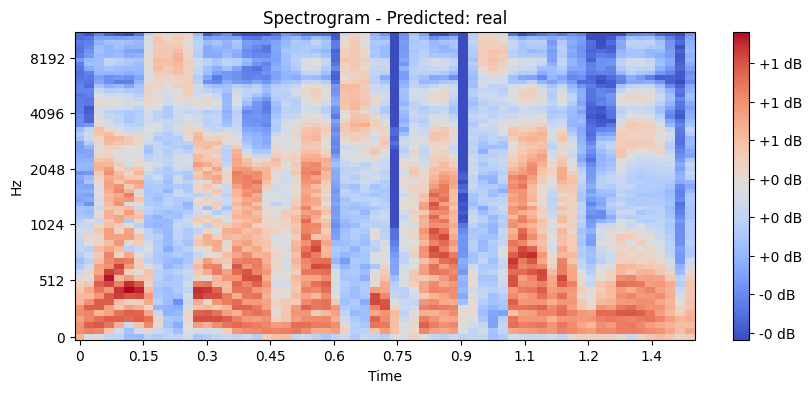


Testing: data\test\file77.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: real (Confidence: 82.40%)


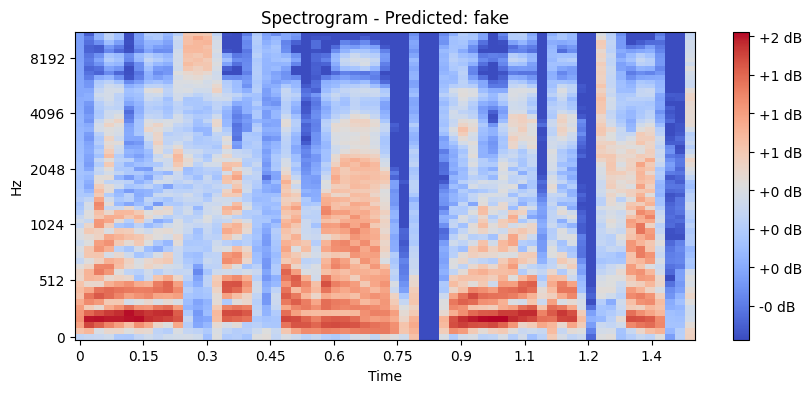


Testing: data\test\file79.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: fake (Confidence: 95.51%)


In [98]:
test_folder_path = os.path.join(DATA_PATH, "test")
if os.path.exists(test_folder_path):
    batch_results = test_audio_folder(test_folder_path)